<a href="https://colab.research.google.com/github/sayakpaul/Emotion-Detection-using-Deep-Learning/blob/master/Emotion_Detection_Using_Deep_Learning_ls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Select TensorFlow 2.0 environment
%tensorflow_version 2.x

You need to get your API key from your Kaggle account to be able to proceed with the following. 

In [0]:
# Google Colab imports for setting up Kaggle
from google.colab import files
files.upload()

In [0]:
# Set up Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download the data
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 79% 73.0M/92.0M [00:00<00:00, 56.5MB/s]
100% 92.0M/92.0M [00:00<00:00, 105MB/s] 
 85% 82.0M/96.6M [00:00<00:00, 69.4MB/s]
100% 96.6M/96.6M [00:00<00:00, 110MB/s] 
 47% 9.00M/19.3M [00:00<00:00, 37.1MB/s]
100% 19.3M/19.3M [00:00<00:00, 55.0MB/s]
 83% 64.0M/77.3M [00:00<00:00, 69.6MB/s]
100% 77.3M/77.3M [00:00<00:00, 105MB/s] 
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 6.12MB/s]


In [0]:
# Unzip dataset
!unzip -qq icml_face_data.csv.zip
!unzip -qq test.csv.zip
!unzip -qq train.csv.zip

In [0]:
# General imports
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# Load up the training dataset
train = pd.read_csv("train.csv")
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [0]:
# Class distribution
train["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Class imbalance noticed.

In [0]:
# Load test dataset
test = pd.read_csv("test.csv")
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


Note on the label mapping:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [0]:
# Function to clean the dataset
# Taken from http://bit.ly/37AUk7f
def clean_data(dataframe):
    image_pixels = np.zeros(shape=(len(dataframe), 48, 48))
    labels = np.zeros(shape=(len(dataframe), ))
    for (i, row) in tqdm(dataframe.iterrows()):
        image = np.fromstring(row["pixels"], dtype=int, sep=' ')
        image = image.reshape(48, 48)
        image = image.astype("float")/255
        
        image_pixels[i] = image
        labels[i] = row["emotion"]
    
    return (image_pixels, labels)

In [0]:
# Clean the training dataset and verify the shapes
(train_pixels, train_labels) = clean_data(train)
train_pixels.shape, train_labels.shape

28709it [00:05, 5223.85it/s]


((28709, 48, 48), (28709,))

In [0]:
# sklearn and other utility imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [0]:
# One-hot encode the labels
le = LabelEncoder().fit(train_labels)
train_labels = to_categorical(le.transform(train_labels), 7)

In [0]:
train_labels.shape

(28709, 7)

In [0]:
# Split the training data into further partial training and validation data
(trainX, valX, trainY, valY) = train_test_split(train_pixels,
    train_labels, test_size=0.15, stratify=train_labels, random_state=42)
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [0]:
# Serialize the data for later reproducibility
np.save("trainX.npy", trainX), np.save("trainY.npy", trainY)
np.save("valX.npy", valX), np.save("valY.npy", valY)

(None, None)

In [0]:
# Load it like this
trainX, trainY = np.load("trainX.npy"), np.load("trainY.npy")
valX, valY = np.load("valX.npy"), np.load("valY.npy")
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [0]:
# Account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
# Define the label mapping
LABELS = {
    0: "Angry", 
    1: "Disgust", 
    2: "Fear",
    3: "Happy", 
    4: "Sad", 
    5: "Surprise", 
    6: "Neutral"
}

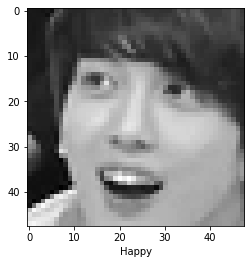

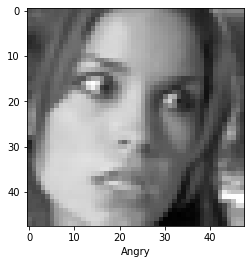

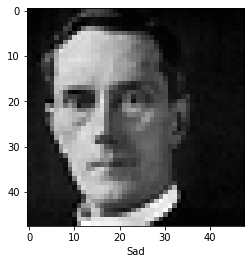

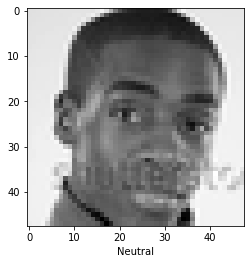

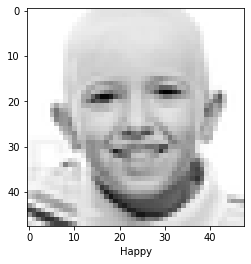

In [0]:
# Spot check the dataset
train_idx = np.random.choice(len(trainX), 5)
for id in train_idx:
    plt.imshow(trainX[id].reshape(48, 48), cmap="gray")
    plt.xlabel(LABELS[np.argmax(trainY[id])])
    plt.show()

For modeling purposes, we are going to use the following three architectures:
- Shallow fully connected network
- Mini InceptionNet or Mini GoogLeNet
- Mini VGGNet

For architectural details and discussions follow this article: https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/. 

In [0]:
# Comes from http://bit.ly/2U8ntCX
!wget https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py

--2020-02-14 13:34:38--  https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5217 (5.1K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   5.09K  --.-KB/s    in 0s      

2020-02-14 13:34:38 (111 MB/s) - ‘models.py’ saved [5217/5217]



In [0]:
# PyImageSearch imports
from models import MiniVGGNetModel
from models import minigooglenet_functional
from models import shallownet_sequential

In [0]:
# Convnets would require a channel dimension
trainX = trainX.reshape(-1, 48, 48, 1)
valX = valX.reshape(-1, 48, 48, 1)

In [0]:
# Set up wandb
!pip install wandb
!wandb login

In [0]:
# Import wandb
import wandb
from wandb.keras import WandbCallback

In [0]:
# Instantiate a data augmentation pipeline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2)
val_aug = ImageDataGenerator()

In [0]:
# To use Label Smoothing we need to use the CategoricalCrossentropy class
from tensorflow.keras.losses import CategoricalCrossentropy

In [0]:
# Train a mini VGG net with data augmentation, SGD & Label Smoothing
wandb.init(project="emotion-detection", entity="sayakpaul", id="vgg-net-da-sgd-ls")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(train_aug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=np.ceil(len(trainX)/64),
    validation_data=val_aug.flow(valX, valY, batch_size=64), 
    validation_steps=np.ceil(len(valX)/64) ,
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

  ...
    to  
  ['...']
Train for 382.0 steps, validate for 68.0 steps
Epoch 1/50
378/382 [============================>.] - ETA: 0s - loss: 2.4428 - accuracy: 0.1861

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


382/382 [==============================] - 18s 47ms/step - loss: 2.4398 - accuracy: 0.1863 - val_loss: 1.8336 - val_accuracy: 0.2675
Epoch 2/50
382/382 [==============================] - 11s 29ms/step - loss: 2.0020 - accuracy: 0.2312 - val_loss: 1.7832 - val_accuracy: 0.3111
Epoch 3/50
382/382 [==============================] - 11s 29ms/step - loss: 1.8750 - accuracy: 0.2555 - val_loss: 1.7567 - val_accuracy: 0.3192
Epoch 4/50
382/382 [==============================] - 11s 29ms/step - loss: 1.8309 - accuracy: 0.2754 - val_loss: 1.7432 - val_accuracy: 0.3295
Epoch 5/50
382/382 [==============================] - 11s 29ms/step - loss: 1.8043 - accuracy: 0.2915 - val_loss: 1.7642 - val_accuracy: 0.3076
Epoch 6/50
382/382 [==============================] - 11s 28ms/step - loss: 1.7817 - accuracy: 0.3035 - val_loss: 2.0642 - val_accuracy: 0.2387
Epoch 7/50
382/382 [==============================] - 11s 29ms/step - loss: 1.7611 - accuracy: 0.3165 - val_loss: 1.7097 - val_accuracy: 0.3432
Epo